# Load Data

In [1]:
# only for macbook with AMD GPU
import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')


In [3]:
! gdown --id 11zufpuePYayZys7vK-uFyTOG9_g8o7zv

Downloading...
From: https://drive.google.com/uc?id=11zufpuePYayZys7vK-uFyTOG9_g8o7zv
To: /Users/youssefabbas/Desktop/Graduation Project/untitled folder 2/all_in_one_MIT_BIH_DATASET_32_5_2021.csv
241MB [01:12, 3.33MB/s] 


In [3]:
data = pd.read_csv('./MIT_BIH_DATASET_Resampled_Filltered_6_2021.csv')

In [4]:
data_new = data.to_numpy()
print(data_new.shape)

(27200, 301)


In [5]:
data, labels = data_new[:, :-1], data_new[:, -1]
print(data.shape, labels.shape)


(27200, 300) (27200,)


In [8]:
!pip install biosppy


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


In [6]:
from biosppy.signals import ecg
from scipy import signal


In [7]:
from sklearn.utils import class_weight


In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)

In [45]:
class_weights

array([0.64700285, 0.89650626, 1.36580467, 0.80342638, 2.76142132])

In [9]:
sampling_rate = float(300)
# filter signal
order = int(0.3 * sampling_rate)
filter_data = np.zeros((len(data),len(data[0])))
for i, (xrow, yrow) in enumerate(zip(data, labels)):
  filtered, _, _ = ecg.st.filter_signal(signal=xrow,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)
  # print(filtered)
  filter_data[i] = filtered


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(filter_data, labels, test_size=0.40, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.50, random_state=42)

In [26]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_valid = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [27]:
X_train.shape

(16320, 300, 1)

In [28]:
X_valid.shape

(5440, 300, 1)

In [29]:
X_test.shape

(5440, 300, 1)

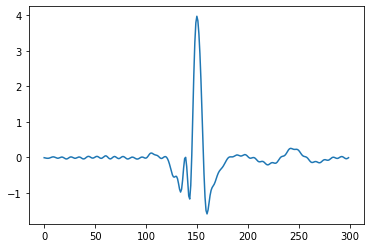

In [30]:
plt.plot(X_train[100])

In [31]:
X_train.shape[1]

300

In [32]:
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    callbacks = [EarlyStopping(monitor='val_loss', patience=5),]
    model.summary()
    import tensorflow as tf

    tf.keras.utils.plot_model(
        model
    )
    history=model.fit(X_train, y_train,epochs=30,callbacks=callbacks,class_weight=class_weights, batch_size=32,validation_data=(X_test,y_test))
    return(model,history)

In [33]:
X_train_ = np.expand_dims(X_train, axis=1)
X_valid_ = np.expand_dims(X_valid, axis=1)
    

In [34]:
y_train_ = to_categorical(y_train)
y_valid_ = to_categorical(y_valid)

In [35]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
model,history=network(X_train,y_train_,X_valid,y_valid_)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 300, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 295, 64)           448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 295, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 146, 64)           12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 146, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 73, 64)            0         
__________

In [36]:
min(history.history['loss'])

0.009078816675087985

In [37]:
X_test_ = np.expand_dims(X_test, axis=1)

In [ ]:
cl

In [38]:
X_test.shape

(5440, 300, 1)

In [39]:
y_valid_ = to_categorical(y_test)

In [40]:
y_test

array([0., 2., 1., ..., 0., 3., 3.])

In [41]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_valid_)
print("test loss, test acc:", results)

Evaluate on test data
5440/5440 [==============================] - 1s 92us/step
test loss, test acc: [0.07396243793122909, 0.9865808823529412]


In [42]:
model.save('CNN_1D.h5')